## Process all OD and Tract data

In [1]:
%matplotlib inline

import pandas as pd
import os
import contextlib
import geopandas as gp
import fiona
import shapely.geometry as geom
import timeit
from IPython.display import clear_output
from pyproj import Geod

#### This next frame needs to be clean up with pathlib

In [ ]:
print(os.getcwd())
fileDir = 'blocks-output' 
os.chdir(fileDir)
input = 'od_original.csv'
output = 'od_chunk_test.csv'

In [3]:
def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) 
  return dist

In [4]:
def chunk_preprocessing(df):
    df['tract_w_geoid'] = df.w_geocode.str[:11]
    df_group = df.groupby(['tract_w_geoid']).sum()
    df_group = df_group[(df_group['S000'] > 2000)]
    top_tracts_list = df_group.index.tolist()
    df2 = df[df['tract_w_geoid'].isin(top_tracts_list)]
    df2['tract_h_geoid'] = df2.h_geocode.str[:11]
    centroids = pd.read_csv('tracts.csv', dtype={'STATEFP': 'object', 'COUNTYFP': 'object', 'TRACTCE': 'object', 'GEOID': 'object', 'INTPTLAT': 'float', 'INTPTLON': 'float'})
    merge_result = pd.merge(df2, centroids,left_on=  ['tract_w_geoid'],right_on= ['GEOID'],how = 'left')
    merge_result = merge_result.drop(['GEOID'], axis=1)
    merge_result = merge_result.rename(columns={'STATEFP': 'w_statefp', 'COUNTYFP': 'w_countyfp', 'TRACTCE': 'w_tractce', 'INTPTLAT': 'w_lat', 'INTPTLON': 'w_lon'})
    merge_result = pd.merge(merge_result, centroids,left_on=  ['tract_h_geoid'],right_on= ['GEOID'],how = 'left')
    merge_result = merge_result.drop(['GEOID'], axis=1)
    merge_result = merge_result.rename(columns={'STATEFP': 'h_statefp', 'COUNTYFP': 'h_countyfp', 'TRACTCE': 'h_tractce', 'INTPTLAT': 'h_lat', 'INTPTLON': 'h_lon'})
    merge_result['distance'] = Distance(merge_result['w_lat'].tolist(),merge_result['w_lon'].tolist(),merge_result['h_lat'].tolist(),merge_result['h_lon'].tolist())
    merge_result['distance'] = merge_result['distance'].apply(lambda x: round(x, decimals))
    merge_limited = merge_result[(merge_result['distance'] < 30000) & (merge_result['distance'] > 15000)]
    merge_limited['geometry'] = merge_limited.apply(lambda x: geom.LineString([(x['w_lon'], x['w_lat'] ), (x['h_lon'],x['h_lat'])]), axis = 1)
    return merge_limited

#### Read the Origin Destination (OD) data into chunk dataframes

In [5]:
%time df_chunk = pd.read_csv(input, dtype={'w_geocode': str,'h_geocode':str,'createdate':str,'Hstatecounty_id': str,'Wstatecounty_id': str}, chunksize=10000000)

CPU times: user 2.55 ms, sys: 2.85 ms, total: 5.4 ms
Wall time: 6.84 ms


In [6]:
chunk_list = []

In [7]:
wgs84_geod = Geod(ellps='WGS84') 
#Distance will be measured on this ellipsoid - more accurate than a spherical method

In [8]:
x=0
decimals = 0   

start = timeit.default_timer()
for df in df_chunk:
    filter_chunk = chunk_preprocessing(df)
    chunk_list.append(filter_chunk)
    clear_output(wait=True)
    stop = timeit.default_timer()
    print('Chunk number:',x)
    print('Length of dataframe:',len(filter_chunk))
    print('Length of list:',len(chunk_list))
    print((stop-start)/60)
    x+=1

Chunk number: 10
Length of dataframe: 1497573
Length of list: 11
34.26217906388333


In [10]:
df['tract_w_geoid'] = df.w_geocode.str[:11]

In [11]:
df_group = df.groupby(['tract_w_geoid']).sum()

In [12]:
df_group = df_group[(df_group['S000'] > 2000)]

In [13]:
top_tracts_list = df_group.index.tolist()

In [14]:
df2 = df[df['tract_w_geoid'].isin(top_tracts_list)]

In [15]:
df2['tract_h_geoid'] = df2.h_geocode.str[:11]

/Users/mark/anaconda3/envs/sandbox2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Read tract centroids into Dask dataframe

In [16]:
%time centroids = pd.read_csv('tracts.csv', dtype={'STATEFP': 'object', 'COUNTYFP': 'object', 'TRACTCE': 'object', 'GEOID': 'object', 'INTPTLAT': 'float', 'INTPTLON': 'float'})

CPU times: user 124 ms, sys: 44.4 ms, total: 168 ms
Wall time: 172 ms


In [17]:
centroids.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,INTPTLAT,INTPTLON
0,01,087,232100,01087232100,32.403765,-85.717259
1,01,101,002201,01101002201,32.335613,-86.307803
2,01,101,002202,01101002202,32.315116,-86.303098
3,01,101,002300,01101002300,32.334080,-86.321932
4,01,101,002400,01101002400,32.341301,-86.335116


#### Merge the centroid data frame on the OD w_geocode column

In [18]:
%time merge_result = pd.merge(df2, centroids,left_on=  ['tract_w_geoid'],right_on= ['GEOID'],how = 'left')
merge_result = merge_result.drop(['GEOID'], axis=1)
merge_result = merge_result.rename(columns={'STATEFP': 'w_statefp', 'COUNTYFP': 'w_countyfp', 'TRACTCE': 'w_tractce', 'INTPTLAT': 'w_lat', 'INTPTLON': 'w_lon'})
merge_result.head()

CPU times: user 2.29 s, sys: 766 ms, total: 3.06 s
Wall time: 3.24 s


,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,createdate,tract_w_geoid,tract_h_geoid,w_statefp,w_countyfp,w_tractce,w_lat,w_lon
0,484530022081004,484530016051026,1,1,0,0,1,0,0,0,0,1,20170919,48453002208,48453001605,48,453,002208,30.276397,-97.653606
1,484530022081004,484530016054013,1,0,1,0,0,0,1,0,0,1,20170919,48453002208,48453001605,48,453,002208,30.276397,-97.653606
2,484530022081004,484530017131013,1,0,1,0,1,0,0,0,0,1,20170919,48453002208,48453001713,48,453,002208,30.276397,-97.653606
3,484530022081004,484530017141041,1,1,0,0,0,0,1,0,0,1,20170919,48453002208,48453001714,48,453,002208,30.276397,-97.653606
4,484530022081004,484530017292007,1,0,1,0,0,0,1,0,0,1,20170919,48453002208,48453001729,48,453,002208,30.276397,-97.653606


#### Merge the centroid data frame on the OD h_geocode column

In [19]:
%time merge_result = pd.merge(merge_result, centroids,left_on=  ['tract_h_geoid'],right_on= ['GEOID'],how = 'left')
merge_result = merge_result.drop(['GEOID'], axis=1)
merge_result = merge_result.rename(columns={'STATEFP': 'h_statefp', 'COUNTYFP': 'h_countyfp', 'TRACTCE': 'h_tractce', 'INTPTLAT': 'h_lat', 'INTPTLON': 'h_lon'})
merge_result.head()

CPU times: user 3.26 s, sys: 911 ms, total: 4.17 s
Wall time: 4.17 s


,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,...,w_statefp,w_countyfp,w_tractce,w_lat,w_lon,h_statefp,h_countyfp,h_tractce,h_lat,h_lon
0,484530022081004,484530016051026,1,1,0,0,1,0,0,0,...,48,453,002208,30.276397,-97.653606,48,453,001605,30.286771,-97.760573
1,484530022081004,484530016054013,1,0,1,0,0,0,1,0,...,48,453,002208,30.276397,-97.653606,48,453,001605,30.286771,-97.760573
2,484530022081004,484530017131013,1,0,1,0,1,0,0,0,...,48,453,002208,30.276397,-97.653606,48,453,001713,30.210793,-97.805299
3,484530022081004,484530017141041,1,1,0,0,0,0,1,0,...,48,453,002208,30.276397,-97.653606,48,453,001714,30.424341,-97.827864
4,484530022081004,484530017292007,1,0,1,0,0,0,1,0,...,48,453,002208,30.276397,-97.653606,48,453,001729,30.202751,-97.829377


In [20]:
# Pyproj docs - https://proj4.org/geodesic.html
# idea source: https://stackoverflow.com/questions/44446862/calculate-distance-between-latitude-and-longitude-in-dataframe

from pyproj import Geod

wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method

def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) 
  return dist

In [21]:
merge_result['distance'] = Distance(merge_result['w_lat'].tolist(),merge_result['w_lon'].tolist(),merge_result['h_lat'].tolist(),merge_result['h_lon'].tolist())

In [22]:
decimals = 0   
merge_result['distance'] = merge_result['distance'].apply(lambda x: round(x, decimals))

In [23]:
#limit the dataframe to any point with an 1.5 hour drive
#source: https://www.timecalculator.net/speed-distance-time-calculator

merge_limited = merge_result[(merge_result['distance'] < 30000) & (merge_result['distance'] > 15000)]
#fayette_limited = fayette[(fayette['distance meters']  > 240000)]
merge_limited.head()

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,...,w_countyfp,w_tractce,w_lat,w_lon,h_statefp,h_countyfp,h_tractce,h_lat,h_lon,distance
2,484530022081004,484530017131013,1,0,1,0,1,0,0,0,...,453,002208,30.276397,-97.653606,48,453,001713,30.210793,-97.805299,16311.0
3,484530022081004,484530017141041,1,1,0,0,0,0,1,0,...,453,002208,30.276397,-97.653606,48,453,001714,30.424341,-97.827864,23446.0
4,484530022081004,484530017292007,1,0,1,0,0,0,1,0,...,453,002208,30.276397,-97.653606,48,453,001729,30.202751,-97.829377,18785.0
5,484530022081004,484530017373005,1,0,1,0,1,0,0,0,...,453,002208,30.276397,-97.653606,48,453,001737,30.214150,-97.880976,22946.0
6,484530022081004,484530017373019,1,0,1,0,1,0,0,0,...,453,002208,30.276397,-97.653606,48,453,001737,30.214150,-97.880976,22946.0


In [24]:

merge_limited['geometry'] = merge_limited.apply(lambda x: geom.LineString([(x['w_lon'], x['w_lat'] ), (x['h_lon'],x['h_lat'])]), axis = 1)


/Users/mark/anaconda3/envs/sandbox2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
chunk_list.append(merge_limited)

### loop ends here

In [9]:
# concat the list into dataframe 
df_concat = pd.concat(chunk_list)

In [10]:
len(df_concat)

17904157

In [11]:
df_concat.head()

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,...,w_tractce,w_lat,w_lon,h_statefp,h_countyfp,h_tractce,h_lat,h_lon,distance,geometry
285,020200006001000,020200002011007,1,0,1,0,0,0,1,0,...,000600,61.224863,-149.837169,02,020,000201,61.333065,-149.573571,18581.0,"LINESTRING (-149.8371693 61.22486329999999, -1..."
286,020200006001000,020200002012002,1,0,1,0,0,0,1,0,...,000600,61.224863,-149.837169,02,020,000201,61.333065,-149.573571,18581.0,"LINESTRING (-149.8371693 61.22486329999999, -1..."
287,020200006001000,020200002031004,1,0,0,1,0,0,1,0,...,000600,61.224863,-149.837169,02,020,000203,61.309822,-149.506022,20132.0,"LINESTRING (-149.8371693 61.22486329999999, -1..."
319,020200006001000,020200028132012,1,0,1,0,1,0,0,1,...,000600,61.224863,-149.837169,02,020,002813,61.115132,-149.616122,17060.0,"LINESTRING (-149.8371693 61.22486329999999, -1..."
330,020200006001001,020200002011006,1,0,1,0,0,0,1,0,...,000600,61.224863,-149.837169,02,020,000201,61.333065,-149.573571,18581.0,"LINESTRING (-149.8371693 61.22486329999999, -1..."


In [14]:

df_concat.to_csv(output)

In [15]:
gdf = gp.GeoDataFrame(df_concat, geometry='geometry')

In [16]:
gdf.head()

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,...,w_tractce,w_lat,w_lon,h_statefp,h_countyfp,h_tractce,h_lat,h_lon,distance,geometry
285,020200006001000,020200002011007,1,0,1,0,0,0,1,0,...,000600,61.224863,-149.837169,02,020,000201,61.333065,-149.573571,18581.0,"LINESTRING (-149.8371693 61.22486329999999, -1..."
286,020200006001000,020200002012002,1,0,1,0,0,0,1,0,...,000600,61.224863,-149.837169,02,020,000201,61.333065,-149.573571,18581.0,"LINESTRING (-149.8371693 61.22486329999999, -1..."
287,020200006001000,020200002031004,1,0,0,1,0,0,1,0,...,000600,61.224863,-149.837169,02,020,000203,61.309822,-149.506022,20132.0,"LINESTRING (-149.8371693 61.22486329999999, -1..."
319,020200006001000,020200028132012,1,0,1,0,1,0,0,1,...,000600,61.224863,-149.837169,02,020,002813,61.115132,-149.616122,17060.0,"LINESTRING (-149.8371693 61.22486329999999, -1..."
330,020200006001001,020200002011006,1,0,1,0,0,0,1,0,...,000600,61.224863,-149.837169,02,020,000201,61.333065,-149.573571,18581.0,"LINESTRING (-149.8371693 61.22486329999999, -1..."


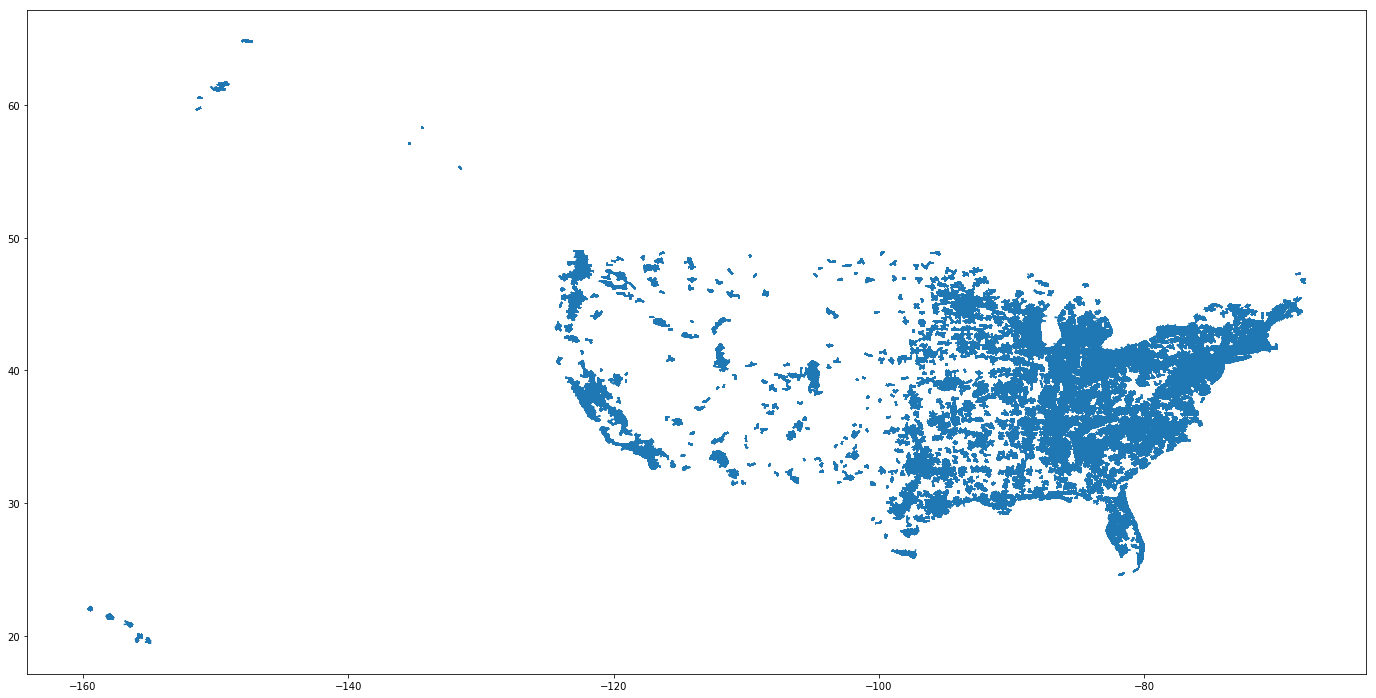

In [17]:
ax =gdf.plot(figsize=(24,24));

In [59]:
len(gdf)

16473303

In [18]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17904157 entries, 285 to 6354756
Data columns (total 27 columns):
w_geocode        object
h_geocode        object
S000             int64
SA01             int64
SA02             int64
SA03             int64
SE01             int64
SE02             int64
SE03             int64
SI01             int64
SI02             int64
SI03             int64
createdate       object
tract_w_geoid    object
tract_h_geoid    object
w_statefp        object
w_countyfp       object
w_tractce        object
w_lat            float64
w_lon            float64
h_statefp        object
h_countyfp       object
h_tractce        object
h_lat            float64
h_lon            float64
distance         float64
geometry         object
dtypes: float64(5), int64(10), object(12)
memory usage: 3.7+ GB


In [23]:
st_list = ['01','04','05','06','08','09','10','11','12','13','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40','41','42','44','45','46','47','48','49','50','51','53','54','55','56']

In [24]:
continental_us = gdf[gdf['w_statefp'].isin(st_list)]

CPU times: user 12min 37s, sys: 4min 11s, total: 16min 49s
Wall time: 22min 22s


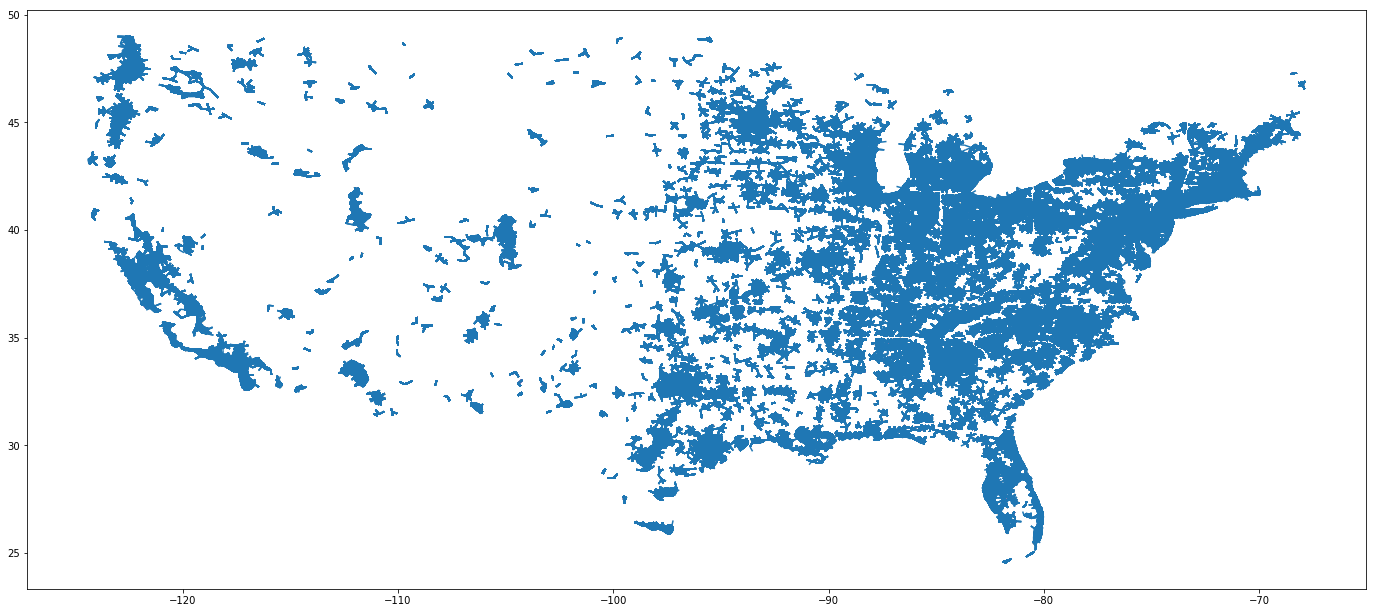

In [25]:
%time ax = continental_us.plot(figsize=(24,24));